# 1. Setup Mario

In [1]:
# !pip install gym_super_mario_bros==7.3.0 nes_py

^C


In [2]:
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [5]:
# Simplify the simple movement variables that the mario can take
SIMPLE_MOVEMENT
# 7 actions that Mario can take

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [6]:
# Setup game
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [7]:
env.action_space # mario environment's action_space = Discrete(256). Too many
# Therefore wrap it in the JoypadSpace

Discrete(256)

In [8]:
# Setup game
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [9]:
env.action_space # SIMPLE_MOVEMENT

Discrete(7)

In [12]:
env.observation_space.shape # 240 pixes, 256*3 RGB

(240, 256, 3)

In [14]:
env.action_space.sample()

5

In [13]:
# Create a flag - restart or not
done = True
# Loop through each frame in the game
for step in range(100000): # Use 100000 frames
    # Start the game to begin with
    if done:
        # Start the game
        env.reset() # If the game is finished -> restart the game
    # Do random action
    state, reward, done, info = env.step(env.action_space.sample())
    # Randomly take action and get the next_state/reward/done/info
    
    # Show the game on the screen
    env.render()
env.close()

C:\Users\iDLaber\miniconda3\envs\baselines\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] 스레드 모드가 설정된 후에는 바꿀 수 없습니다
  warnings.warn(str(err))
C:\Users\iDLaber\miniconda3\envs\baselines\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


KeyboardInterrupt: 

In [24]:
env.step(1)[0] # State pixel data
env.step(1)[1] # Reward
env.step(1)[2] # Done
env.step(1)[3] # Additional information

{'coins': 0,
 'flag_get': False,
 'life': 2,
 'score': 0,
 'stage': 1,
 'status': 'small',
 'time': 400,
 'world': 1,
 'x_pos': 46,
 'x_pos_screen': 46,
 'y_pos': 79}

# 2. Preprocess Data
- Rubbish Data = Rubbish AI
- We already wrapped the environment with the JoypadSpace, but still need an additional wrapper

In [ ]:
# Install pytorch - already existed.
# If you want to use GPU, then you should firstly install pytorch and then
# install baselines

In [27]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
# - FrameStack: Capture the couple of frames while playing the Mario (Time-Consequences - LSTM)
#               Can know how the mario to move in, how the enemy move in etc.
#               Therefore, stacks the pictures together to know the time-changing behavior
# - GrayScaleObservation: Color env -> Gray env / Reduce the amount of information.
from gym.wrappers import FrameStack, GrayScaleObservation
# Import Vectorization Wrappers
# Vectorization wrappers : Transform the data into the vectorization information
# VecFrameStack : For using the FrameStack Data
# DummyVecEnv : For using the basic data
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

In [49]:
# Wrap our environment into the additional wrappers
# 1. Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# 2. Simplify the controls
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# 3. Grayscale
env = GrayScaleObservation(env, keep_dim = True)
# 4. Wrap inside the Dummy Environment
env = DummyVecEnv([lambda:env])
# 5. Stack the frames
env = VecFrameStack(env, 4, channels_order = 'last') # 4 for stacks

In [50]:
state = env.reset() # 240, 256, 3 -> 240,256,1 (Gray Scale Observation)
state.shape # VecFrameStack : 240,256,1 -> 240,256,4

(1, 240, 256, 4)

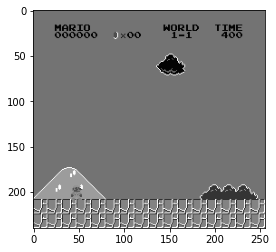

In [51]:
plt.imshow(state[0])

In [72]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [73]:
state, reward, done, info = env.step([env.action_space.sample()])
# This is vector space, so the action also need to be added as a vector

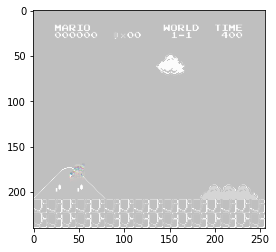

In [74]:
plt.imshow(state[0])

In [79]:
state= env.reset()

In [81]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [96]:
state, reward, done, info = env.step([5])# Jump

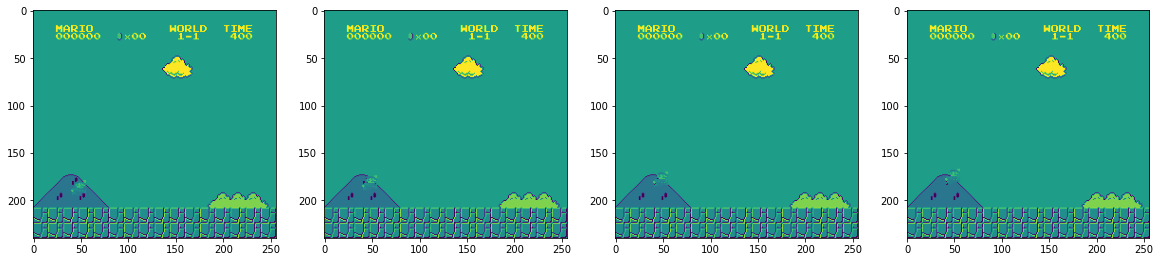

In [97]:
plt.figure(figsize = (20,8))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

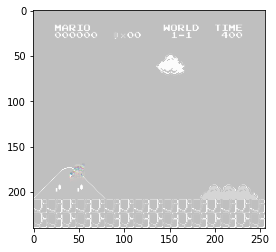

In [76]:
# Use Matplotlib to show the game frame
plt.imshow(state[0]) # 2. Change Color images -> Gray images

In [41]:
 new_state = env.reset()

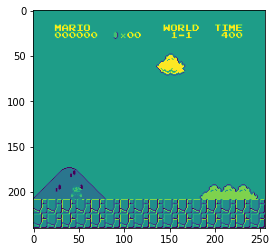

In [42]:
plt.imshow(new_state)

In [43]:
new_state.shape # If no keep_dim -> output: (240,256)

(240, 256, 1)

In [44]:
print(240*256*3, ' Change into ', 240*256*1)

184320  Change into  61440


# 3. Train the RL Model


In [98]:
# import dependencies - stable_baselines3
# import os for file path management
import os
# Import PPO for algorithm
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [99]:
# Logging & Callback Module
# But the one NN model = 232 Mb. It is good not to store it.
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [105]:
CHECKPOINT_DIR = './SuperMario/Train'
LOG_DIR='./SuperMario/logs'

In [106]:
# Setup model saving callbacks
callback = TrainAndLoggingCallback(check_freq = 10000, save_path = CHECKPOINT_DIR)

In [109]:
# This is the AI model started (MlpPolicy: Tabular Data / CnnPolicy: Image Data)
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log = LOG_DIR, learning_rate = 0.000001, n_steps=512)
# 512 frames -> 1 update

Using cpu device
Wrapping the env in a VecTransposeImage.


In [ ]:
# Train the AI model this is where the AI model starts to learn
model.learn(total_timesteps=100000, callback = callback)

Logging to ./SuperMario/logs\PPO_1


C:\Users\iDLaber\miniconda3\envs\baselines\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 77  |
|    iterations      | 1   |
|    time_elapsed    | 6   |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 14           |
|    iterations           | 2            |
|    time_elapsed         | 72           |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 6.309734e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.95        |
|    explained_variance   | 0.00673      |
|    learning_rate        | 1e-06        |
|    loss                 | 93.7         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000489    |
|    value_loss           | 279          |
------------------------------------------
-----------------------

------------------------------------------
| time/                   |              |
|    fps                  | 8            |
|    iterations           | 13           |
|    time_elapsed         | 799          |
|    total_timesteps      | 6656         |
| train/                  |              |
|    approx_kl            | 3.058964e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.95        |
|    explained_variance   | -0.00189     |
|    learning_rate        | 1e-06        |
|    loss                 | 0.114        |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.000382    |
|    value_loss           | 0.278        |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 8             |
|    iterations           | 14            |
|    time_elapsed         | 871           |
|    t

In [ ]:
# model.save('test_model') # -> Save as a zip file in the present location

# 4. Test it Out

In [ ]:
# Load model
# model = PPO.load('./train/best_model_100000')

In [ ]:
state = env.reset()

In [ ]:
model.predict(state) # The predicted action of the AI model

In [ ]:
SIMPLE_MOVEMENT(model.preidct(state)[0][0])

In [ ]:
# start game
state = env.reset()
while True:
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()